# Explore FeatureStore & Data Preparation Pipeline

This notebook demonstrates how to:
1. Run the data preparation pipeline
2. Explore **long format** data (raw parcellator output)
3. Load **wide format** features per metric
4. Use TIV (Total Intracranial Volume) for normalization
5. Prepare data for regional brain age modeling

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# NeuroAlign imports
from neuroalign.data.preprocessing import (
    FeatureStore,
    DataPreparationPipeline,
    PipelineConfig,
    DataPaths,
    ModalityConfig,
    OutputConfig,
    ANATOMICAL_METRICS,  # Available metrics: volume_mm3, mean, std, median, sum, etc.
)
from neuroalign.data.loaders import AnatomicalLoader, DiffusionLoader

print(f"Available anatomical metrics: {ANATOMICAL_METRICS}")

Available anatomical metrics: ['volume_mm3', 'mean', 'std', 'median', 'sum', 'robust_std', 'mad_median']


## 1. Configuration from Environment

In [2]:
# Helper to get paths from env
def get_path(var: str) -> Path | None:
    val = os.getenv(var)
    return Path(val).expanduser() if val else None

# Print current configuration
print("Current Configuration:")
print(f"  SESSIONS_CSV: {get_path('SESSIONS_CSV')}")
print(f"  CAT12_ROOT: {get_path('CAT12_ROOT')}")
print(f"  CAT12_ATLAS_ROOT: {get_path('CAT12_ATLAS_ROOT')}")
print(f"  QSIPARC_PATH: {get_path('QSIPARC_PATH')}")
print(f"  QSIRECON_PATH: {get_path('QSIRECON_PATH')}")
print(f"  ATLAS_NAME: {os.getenv('ATLAS_NAME', '4S456Parcels')}")

Current Configuration:
  SESSIONS_CSV: /home/galkepler/Downloads/linked_sessions.csv
  CAT12_ROOT: /media/storage/yalab-dev/BIDS/derivatives/CAT12.9_2577.new
  CAT12_ATLAS_ROOT: /mnt/62/Processed_Data/derivatives/qsirecon/atlases
  QSIPARC_PATH: /mnt/62/Processed_Data/derivatives/qsiparc
  QSIRECON_PATH: /mnt/62/Processed_Data/derivatives/qsirecon
  ATLAS_NAME: 4S456Parcels


In [3]:
# sessions = pd.read_csv("/home/galkepler/Downloads/linked_sessions.csv")
# sessions_test = sessions.sample(n=100, random_state=42)
# # save session_id as string
# sessions_test["session_id"] = sessions_test["session_id"].astype(int).astype(str)
# sessions_test.to_csv("/home/galkepler/Downloads/linked_sessions_test.csv", index=False)

## 2. Run the Data Preparation Pipeline

This will load all data and save to a FeatureStore. If data already exists, it will only load new sessions (unless `force=True`).

In [4]:
# Configure the pipeline
# OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR = Path("/media/storage/neuroalign/data")

config = PipelineConfig(
    paths=DataPaths(
        # sessions_csv=get_path("SESSIONS_CSV"),
        sessions_csv=Path("/home/galkepler/Downloads/linked_sessions_test.csv"),
        cat12_root=get_path("CAT12_ROOT"),
        atlas_root=get_path("CAT12_ATLAS_ROOT"),
        qsiparc_path=get_path("QSIPARC_PATH"),
        qsirecon_path=get_path("QSIRECON_PATH"),
        output_dir=OUTPUT_DIR,
    ),
    modalities=ModalityConfig(
        anatomical=True,
        diffusion=True,
        gray_matter=True,
        white_matter=True,
        cortical_thickness=True,
    ),
    atlas_name=os.getenv("ATLAS_NAME", "4S456Parcels"),
    n_jobs=4,  # Parallel workers for anatomical loading
    force=False,  # Set to True to reload all data
)

print("Pipeline configured")
print(f"  Output: {config.paths.output_dir}")
print(f"  Force reload: {config.force}")

Pipeline configured
  Output: /media/storage/neuroalign/data
  Force reload: False


In [5]:
# from neuroalign.data.loaders.anatomical import _select_xml

# for _, row in sessions_test.iterrows():
#             subject = row["subject_code"]
#             session = row["session_id"]
#             if isinstance(session, float) or isinstance(session, int):
#                 session = str(int(session))
#             if isinstance(subject, float) or isinstance(subject, int):
#                 subject = (
#                     str(int(subject)).replace("_", "").replace("-", "").replace("\t", "").zfill(4)
#                 )
#             candidate_dir = config.paths.cat12_root / f"sub-{subject}" / f"ses-{session}" / "anat"
#             # print(candidate_dir.exists())
#             candidate_xml = _select_xml(candidate_dir, subject, session)
#             print(f"Subject: {subject}, Session: {session}, XML: {candidate_xml}")

In [ ]:
# Run the pipeline (uncomment to execute)
# This may take a while depending on data size

pipeline = DataPreparationPipeline(config)
result = pipeline.run()

print(f"\nPipeline complete!")
print(f"  New sessions: {result.n_new_sessions}")
print(f"  Skipped: {result.n_skipped_sessions}")
print(f"  Total in store: {result.metadata['n_sessions']}")

Loading diffusion data:  50%|█████     | 50/100 [08:45<10:54, 13.09s/it]  

## 3. Explore the FeatureStore

The FeatureStore organizes data in two formats:
- **Long format**: Raw parcellator output with ALL columns (volume_mm3, mean, std, median, etc.)
- **Wide format**: One Parquet file per metric for efficient loading

It also stores TIV (Total Intracranial Volume) separately for volume normalization.

In [6]:
# Load the feature store
store = FeatureStore(OUTPUT_DIR)

# Check if store exists
if store.exists():
    print("FeatureStore found!")
    summary = store.summary()
    print(f"\nSummary:")
    print(f"  Sessions: {summary['n_sessions']}")
    print(f"  Subjects: {summary['n_subjects']}")
    print(f"  Atlas: {summary['atlas_name']}")
    print(f"  Has TIV: {summary['has_tiv']}")
    print(f"  Created: {summary['created_at']}")
    
    print(f"\nLong formats available: {len(summary['long_formats'])}")
    for fmt in summary['long_formats']:
        print(f"  - {fmt}")
    
    print(f"\nWide features available: {summary['n_wide_features']}")
else:
    print("FeatureStore not found - run the pipeline first!")

FeatureStore found!

Summary:
  Sessions: 3195
  Subjects: 2611
  Atlas: 4S456Parcels
  Has TIV: True
  Created: 2026-01-15T18:31:04.111013

Long formats available: 8
  - anatomical_gm
  - anatomical_wm
  - anatomical_ct
  - diffusion_DSIStudio
  - diffusion_DIPYDKI
  - diffusion_DIPYMAPMRI
  - diffusion_AMICONODDI
  - diffusion_MRtrix3_act-HSVS

Wide features available: 763


In [8]:
# List available wide-format features
print("Available wide-format features:")
print("\nAnatomical:")
for feat in store.list_features(modality="anatomical"):
    info = store.get_feature_info(feat)
    print(f"  - {feat}: {info.n_regions} regions, {info.n_sessions} sessions")

print("\nDiffusion (first 10):")
diff_feats = store.list_features(modality="diffusion")
for feat in diff_feats[:10]:
    info = store.get_feature_info(feat)
    print(f"  - {feat}: {info.n_regions} regions, {info.n_sessions} sessions")

if len(diff_feats) > 10:
    print(f"  ... and {len(diff_feats) - 10} more")

Available wide-format features:

Anatomical:
  - ct_mad_median: 456 regions, 3195 sessions
  - ct_mean: 456 regions, 3195 sessions
  - ct_median: 456 regions, 3195 sessions
  - ct_robust_std: 456 regions, 3195 sessions
  - ct_std: 456 regions, 3195 sessions
  - ct_sum: 456 regions, 3195 sessions
  - ct_volume_mm3: 456 regions, 3195 sessions
  - gm_mad_median: 456 regions, 3195 sessions
  - gm_mean: 456 regions, 3195 sessions
  - gm_median: 456 regions, 3195 sessions
  - gm_robust_std: 456 regions, 3195 sessions
  - gm_std: 456 regions, 3195 sessions
  - gm_sum: 456 regions, 3195 sessions
  - gm_volume_mm3: 456 regions, 3195 sessions
  - tiv: 1 regions, 3195 sessions
  - wm_mad_median: 456 regions, 3195 sessions
  - wm_mean: 456 regions, 3195 sessions
  - wm_median: 456 regions, 3195 sessions
  - wm_robust_std: 456 regions, 3195 sessions
  - wm_std: 456 regions, 3195 sessions
  - wm_sum: 456 regions, 3195 sessions
  - wm_volume_mm3: 456 regions, 3195 sessions

Diffusion (first 10):
  - 

## 4. Explore Long Format Data

Long format preserves ALL columns from the parcellator output. This is useful for:
- Exploring different summary statistics (mean, median, std, etc.)
- Custom aggregations not available in wide format
- Quality control and debugging

In [9]:
# Load gray matter long format data
gm_long = store.load_long("anatomical_gm")
print(f"GM Long Format: {gm_long.shape}")
print(f"\nAll columns: {gm_long.columns.tolist()}")
print(f"\nAvailable metrics: {[c for c in ANATOMICAL_METRICS if c in gm_long.columns]}")
gm_long.head()

GM Long Format: (1465128, 81)

All columns: ['index', 'label', 'network_label', 'label_7network', 'index_17network', 'label_17network', 'network_label_17network', 'atlas_name', 'network_id', 'volume_mm3', 'voxel_count', 'z_filtered_mean', 'z_filtered_std', 'iqr_filtered_mean', 'iqr_filtered_std', 'robust_mean', 'robust_std', 'mad_median', 'mean', 'std', 'median', 'sum', 'ScanID', 'Status', 'Lab', 'Name', 'ID', 'Cellular No.', 'Email', 'Gender', 'DOB', 'ScanDate', 'Age@Scan', 'Weight', 'Height', 'Protocol', 'Study', 'Group', 'Unnamed: 16', 'ScanTag', 'SubjectCode', 'HebrewName', 'No of Scan', 'PrivacyStatement', 'UID', 'session_id', 'subject_code', 'dicom_path', 'match_type', 'qualitymeasures_SurfaceEulerNumber', 'qualitymeasures_SurfaceDefectArea', 'qualitymeasures_SurfaceDefectNumber', 'qualitymeasures_SurfaceIntensityRMSE', 'qualitymeasures_SurfacePositionRMSE', 'qualitymeasures_res_RMS', 'qualitymeasures_res_BB', 'qualitymeasures_res_ECR', 'qualitymeasures_contrast', 'qualitymeasure

,index,label,network_label,label_7network,index_17network,label_17network,network_label_17network,atlas_name,network_id,volume_mm3,...,qualityratings_SurfaceIntensityRMSE,qualityratings_SurfacePositionRMSE,qualityratings_SIQR,qualityratings_SIQR3rms2,qualityratings_SIQR4rms2,qualityratings_SIQR4rms8,qualityratings_IQR,modality,metric,tiv
0,1,LH_Vis_1,Vis,7Networks_LH_Vis_1,61.0,17Networks_LH_DorsAttnA_TempOcc_2,DorsAttnA,4S456,NaN,2875.500,...,1.435645,1.402251,1.679635,1.679635,1.504211,1.625439,1.655196,gm,volume,1588.14
1,2,LH_Vis_2,Vis,7Networks_LH_Vis_2,193.0,17Networks_LH_DefaultC_PHC_2,DefaultC,4S456,NaN,3398.625,...,1.435645,1.402251,1.679635,1.679635,1.504211,1.625439,1.655196,gm,volume,1588.14
2,3,LH_Vis_3,Vis,7Networks_LH_Vis_3,1.0,17Networks_LH_VisCent_ExStr_1,VisCent,4S456,NaN,2592.000,...,1.435645,1.402251,1.679635,1.679635,1.504211,1.625439,1.655196,gm,volume,1588.14
3,4,LH_Vis_4,Vis,7Networks_LH_Vis_4,13.0,17Networks_LH_VisPeri_ExStrInf_1,VisPeri,4S456,NaN,3418.875,...,1.435645,1.402251,1.679635,1.679635,1.504211,1.625439,1.655196,gm,volume,1588.14
4,5,LH_Vis_5,Vis,7Networks_LH_Vis_5,2.0,17Networks_LH_VisCent_ExStr_2,VisCent,4S456,NaN,3395.250,...,1.435645,1.402251,1.679635,1.679635,1.504211,1.625439,1.655196,gm,volume,1588.14


In [10]:
# Compare different metrics for the same modality
print("Different summary statistics for Gray Matter:")
for metric in ["volume_mm3", "mean", "median"]:
    if metric in gm_long.columns:
        vals = gm_long[metric].dropna()
        print(f"  {metric}: min={vals.min():.3f}, max={vals.max():.3f}, mean={vals.mean():.3f}")

Different summary statistics for Gray Matter:
  volume_mm3: min=54.000, max=30985.875, mean=2850.857
  mean: min=0.000, max=1.067, mean=0.454
  median: min=0.000, max=1.111, mean=0.497


In [17]:
# Load wide format feature for modeling
# Note: Feature names follow pattern {modality}_{metric} e.g., gm_volume_mm3, ct_mean
gm_wide = store.load_feature("gm_volume_mm3")
print(f"GM Volume Wide Format: {gm_wide.shape}")

# Get region names
regions = store.get_regions("gm_volume_mm3")
print(f"Number of regions: {len(regions)}")
print(f"First 10 regions: {regions[:10]}")
gm_wide.head()

GM Volume Wide Format: (3195, 459)
Number of regions: 456
First 10 regions: ['Cerebellar_Region1', 'Cerebellar_Region10', 'Cerebellar_Region2', 'Cerebellar_Region3', 'Cerebellar_Region4', 'Cerebellar_Region5', 'Cerebellar_Region6', 'Cerebellar_Region7', 'Cerebellar_Region8', 'Cerebellar_Region9']


,subject_code,session_id,Cerebellar_Region1,Cerebellar_Region10,Cerebellar_Region2,Cerebellar_Region3,Cerebellar_Region4,Cerebellar_Region5,Cerebellar_Region6,Cerebellar_Region7,...,RH_Vis_29,RH_Vis_3,RH_Vis_30,RH_Vis_4,RH_Vis_5,RH_Vis_6,RH_Vis_7,RH_Vis_8,RH_Vis_9,AGE
0,0048R,202303161349,20536.875,11346.75,18623.25,10833.750,26240.625,20928.375,30972.375,11795.625,...,2953.125,2440.125,2109.375,3071.25,3756.375,4529.25,1144.125,2311.875,4549.5,31.62
1,0069R,202211021641,20567.250,11346.75,18623.25,10837.125,26240.625,20955.375,30979.125,11795.625,...,2953.125,2440.125,2109.375,3071.25,3756.375,4529.25,1144.125,2311.875,4549.5,38.27
2,0069R,202304091325,20540.250,11346.75,18616.50,10833.750,26240.625,20918.250,30975.750,11795.625,...,2953.125,2440.125,2109.375,3071.25,3756.375,4529.25,1144.125,2311.875,4549.5,38.71
3,0110R,202211291534,20516.625,11346.75,18623.25,10833.750,26240.625,20914.875,30958.875,11795.625,...,2953.125,2440.125,2109.375,3071.25,3756.375,4529.25,1144.125,2311.875,4549.5,29.69
4,0110R,202212061427,20530.125,11346.75,18623.25,10837.125,26240.625,20948.625,30972.375,11795.625,...,2953.125,2440.125,2109.375,3071.25,3756.375,4529.25,1144.125,2311.875,4549.5,29.71


In [18]:
tiv = store.load_tiv()

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf





# Merge TIV into wide format for analysis, merge on "session_id"
gm_wide_with_tiv = gm_wide.copy()
gm_wide_with_tiv = gm_wide_with_tiv.merge(tiv, on="session_id", how="left")

hipp = gm_wide_with_tiv.filter(like="Hipp")
# hipp["TIV"] = gm_wide_with_tiv["tiv"]
hipp["session_id"] = gm_wide_with_tiv["session_id"]
hipp["age"] = gm_wide_with_tiv["AGE"]
hipp = hipp[hipp["age"] > 18]
hipp["age_c"] = hipp["age"] - hipp["age"].mean()

hipp = hipp.dropna()


/tmp/ipykernel_23940/4102344651.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hipp["session_id"] = gm_wide_with_tiv["session_id"]
/tmp/ipykernel_23940/4102344651.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hipp["age"] = gm_wide_with_tiv["AGE"]


In [20]:
import statsmodels.api as sm
from pygam import LinearGAM, s, f, l
# estimate weights based on age (to mitigate age bias in sample, use binning)
def estimate_weights(df: pd.DataFrame, bins: int = 10) -> pd.Series:
    df = df.copy()
    df["age_bin"] = pd.cut(df["age"], bins=bins)
    bin_counts = df["age_bin"].value_counts().to_dict()
    weights = df["age_bin"].map(lambda x: 1 / bin_counts[x])
    return weights
# write a function to estimate the "peak" age of hippocampal cortical thickness based on a quadratic model
def estimate_peak_age(df: pd.DataFrame, region_col: str) -> float:
    model = smf.wls(formula=f"{region_col} ~ age_c + I(age_c ** 2)", data=df, weights=df["weights"]).fit()
    a = model.params["I(age_c ** 2)"]
    b = model.params["age_c"]
    peak_age_c = -b / (2 * a)
    peak_age = peak_age_c + df["age"].mean()
    return model, peak_age

# Write a function to do GAM for a given region
def do_gam(df: pd.DataFrame, region_col: str):
    lams = np.random.rand(100, 1)  # random points on [0, 1], with shape (100, 3)
    lams = lams * 6 - 3  # shift values to -3, 3
    lams = 10**lams  # transforms values to 1e-3, 1e3
    X = df["age_c"].values.reshape(-1, 1)
    y = df[region_col].values
    # gam = LinearGAM(s(0, constraints="monotonic_dec")).fit(X, y)
    gam = LinearGAM()
    gam.gridsearch(X, y, lam=lams)
    
    return gam

def find_peaks_in_gam(gam: LinearGAM, age_mean: float) -> float:
    # Derivative of GAM
    XX = gam.generate_X_grid(term=0,n=1000)
    gamy = gam.predict(XX)
    yprime = np.gradient(gamy, XX.squeeze())
    # Find zero crossings in derivative
    zero_crossings = np.where(np.diff(np.sign(yprime)))[0]
    peak_ages = []
    for zc in zero_crossings:
        peak_age_c = XX[zc][0]
        peak_age = peak_age_c + age_mean
        peak_ages.append(peak_age)
    return peak_ages

# hipp["weights"] = estimate_weights(hipp)

In [21]:
m = do_gam(hipp, "RH_Hippocampus")
peaks = find_peaks_in_gam(m, hipp["age"].mean())
print(f"Estimated peak ages for LH_Hippocampus: {peaks}")

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
/home/galkepler/Projects/neuroalign/.venv/lib/python3.11/site-packages/pygam/pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2["explained_deviance"] = 1.0 - full_d.sum() / null_d.sum()
/home/galkepler/Projects/neuroalign/.venv/lib/python3.11/site-packages/pygam/pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2["explained_deviance"] = 1.0 - full_d.sum() / null_d.sum()
/home/galkepler/Projects/neuroalign/.venv/lib/python3.11/site-packages/pygam/pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2["explained_deviance"] = 1.0 - full_d.sum() / null_d.sum()
/home/galkepler/Projects/neuroalign/.venv/lib/python3.11/site-packages/pygam/pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2["explained_deviance"] = 1.0 - full_d.sum() / null_d.sum()
/home/galkepler/Projects/neuroalign/.venv/lib/python3.11/sit

Estimated peak ages for LH_Hippocampus: [np.float64(32.74122122122122)]


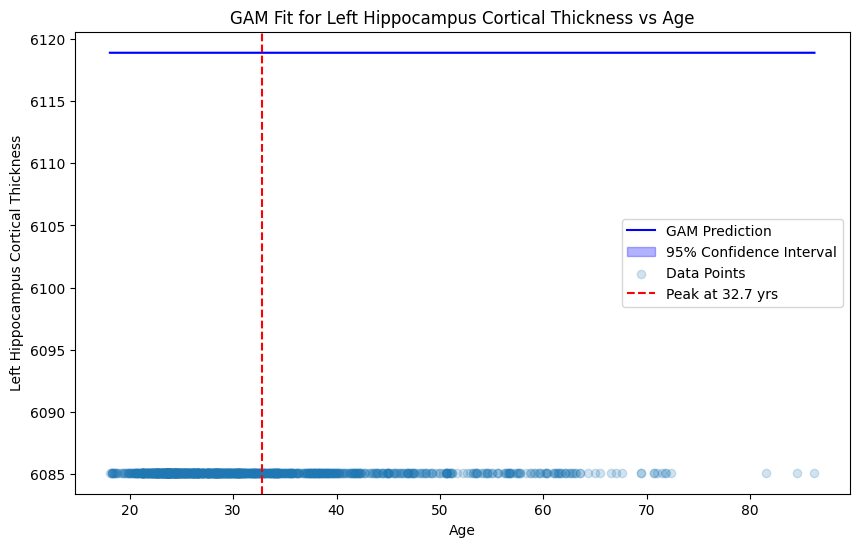

In [22]:
# get predictions and CI
xx = m.generate_X_grid(term=0, n=4000)
preds = m.predict(xx)
conf_int = m.confidence_intervals(xx, width=0.95)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(xx[:, 0] + hipp["age"].mean(), preds, label="GAM Prediction", color="blue")
plt.fill_between(
    xx[:, 0] + hipp["age"].mean(),
    conf_int[:, 0],
    conf_int[:, 1],
    color="blue",
    alpha=0.3,
    label="95% Confidence Interval",
)
plt.scatter(hipp["age"], hipp["LH_Hippocampus"], alpha=0.2, label="Data Points")
for peak in peaks:
    plt.axvline(x=peak, color="red", linestyle="--", label=f"Peak at {peak:.1f} yrs")
plt.xlabel("Age")
plt.ylabel("Left Hippocampus Cortical Thickness")
plt.title("GAM Fit for Left Hippocampus Cortical Thickness vs Age")
plt.legend()


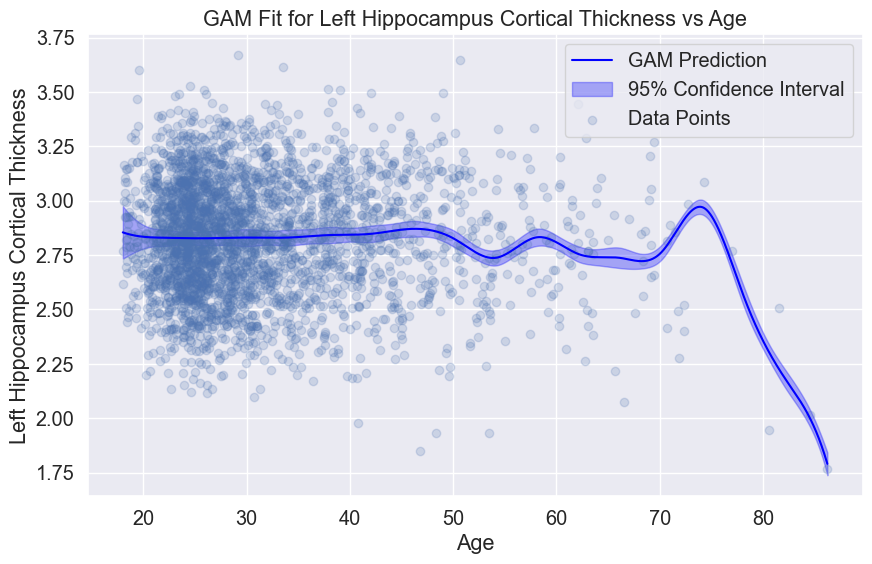

In [156]:
# get predictions and CI
xx = m.generate_X_grid(term=0, n=4000)
preds = m.predict(xx)
conf_int = m.confidence_intervals(xx, width=0.95)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(xx[:, 0] + hipp["age"].mean(), preds, label="GAM Prediction", color="blue")
plt.fill_between(
    xx[:, 0] + hipp["age"].mean(),
    conf_int[:, 0],
    conf_int[:, 1],
    color="blue",
    alpha=0.3,
    label="95% Confidence Interval",
)
plt.scatter(hipp["age"], hipp["LH_Hippocampus"], alpha=0.2, label="Data Points")
plt.xlabel("Age")
plt.ylabel("Left Hippocampus Cortical Thickness")
plt.title("GAM Fit for Left Hippocampus Cortical Thickness vs Age")
plt.legend()


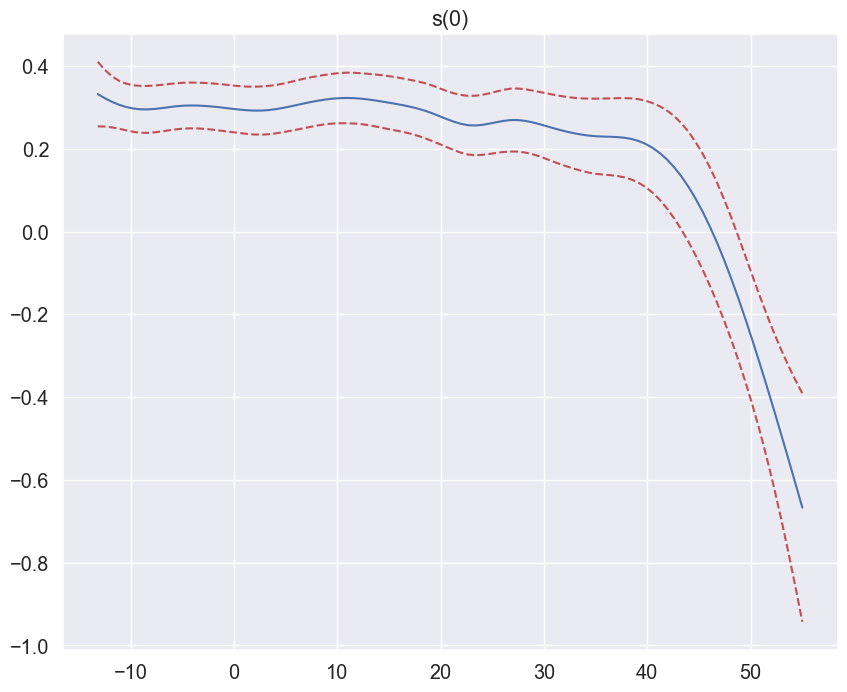

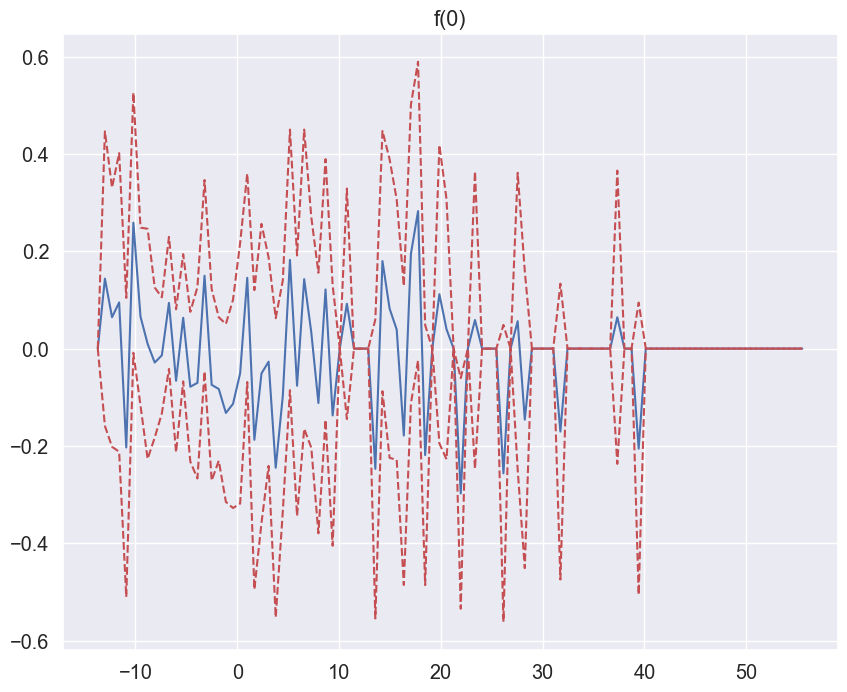

In [100]:
for i, term in enumerate(m.terms):
    if term.isintercept:
        continue

    XX = m.generate_X_grid(term=i)
    pdep, confi = m.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c="r", ls="--")
    plt.title(repr(term))
    plt.show()


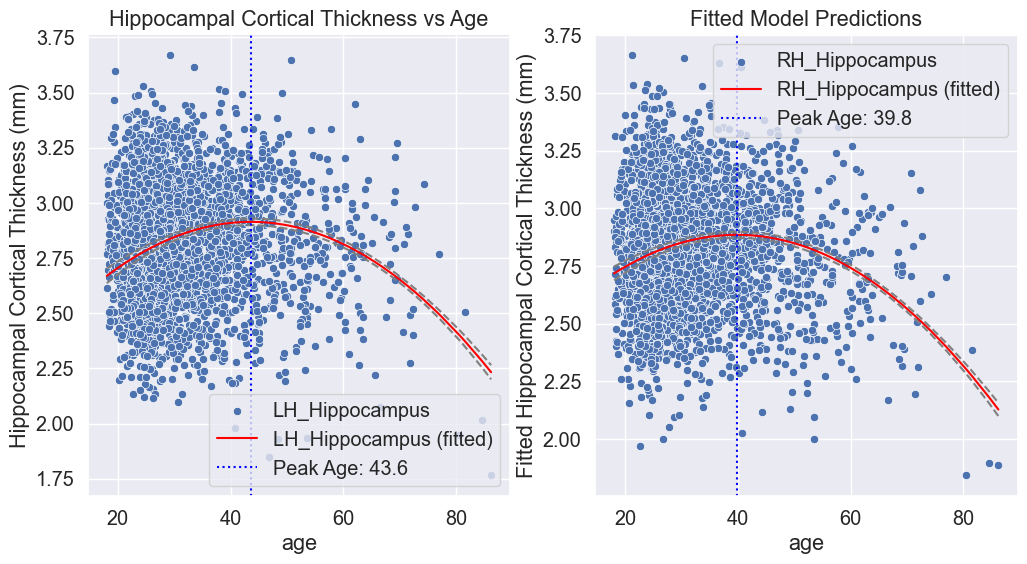

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

i = 0
for col in hipp.columns:
    if "hipp" in col.lower():
        sns.scatterplot(data=hipp, x="age", y=col, ax=axes[i], label=col)
        model, peak_age = estimate_peak_age(hipp, col)
        hipp[f"{col}_pred"] = model.fittedvalues
        hipp[f"{col}_ci_lower"], hipp[f"{col}_ci_upper"] = model.get_prediction().conf_int().T
        sns.lineplot(
            data=hipp, x="age", y=f"{col}_pred", ax=axes[i], label=f"{col} (fitted)", color="red"
        )
        sns.lineplot(
            data=hipp, x="age", y=f"{col}_ci_lower", ax=axes[i], linestyle="--", color="gray"
        )
        ax = sns.lineplot(
            data=hipp, x="age", y=f"{col}_ci_upper", ax=axes[i], linestyle="--", color="gray"
        )
        ax.axvline(peak_age, linestyle=":", color="blue", label=f"Peak Age: {peak_age:.1f}")
        ax.legend()

        i += 1
axes[0].set_title("Hippocampal Cortical Thickness vs Age")
axes[0].set_ylabel("Hippocampal Cortical Thickness (mm)")
axes[1].set_title("Fitted Model Predictions")
axes[1].set_ylabel("Fitted Hippocampal Cortical Thickness (mm)")
plt.legend()
plt.show()


## 5. TIV (Total Intracranial Volume) Debugging & Normalization

TIV is now stored both as a standalone file AND as an anatomical feature.
Use this section to debug TIV calculation issues.

In [ ]:
# Debug TIV Configuration
print("=== TIV Configuration ===")
print(f"MATLAB_BIN: {os.getenv('MATLAB_BIN', 'NOT SET')}")
print(f"SPM_PATH: {os.getenv('SPM_PATH', 'NOT SET')}")
print(f"CAT12_PATH: {os.getenv('CAT12_PATH', 'NOT SET')}")
print(f"TIV_TEMPLATE: {os.getenv('TIV_TEMPLATE', 'NOT SET')}")

# Check if paths exist
for var in ['MATLAB_BIN', 'SPM_PATH', 'CAT12_PATH', 'TIV_TEMPLATE']:
    val = os.getenv(var)
    if val:
        exists = Path(val).exists()
        print(f"  {var} exists: {exists}")
    else:
        print(f"  {var}: Not configured")

In [ ]:
# Debug TIV extraction from AnatomicalLoader
from neuroalign.data.loaders import AnatomicalLoader

debug_loader = AnatomicalLoader(
    cat12_root=get_path("CAT12_ROOT"),
    atlas_root=get_path("CAT12_ATLAS_ROOT"),
    atlas_name="4S456Parcels",
)

print("=== AnatomicalLoader TIV Config ===")
print(f"TIV enabled: {debug_loader.tiv_config.enabled}")
print(f"MATLAB bin: {debug_loader.tiv_config.matlab_bin}")
print(f"SPM path: {debug_loader.tiv_config.spm_path}")
print(f"CAT12 path: {debug_loader.tiv_config.cat12_path}")
print(f"TIV template: {debug_loader.tiv_config.tiv_template}")

In [ ]:
# Test loading a single session and check for TIV column
test_subject = "0048R"  # Change to a subject you know exists
test_session = "202303161349"

# Reset XML files list
debug_loader._xml_files = []

# Load single session WITH TIV
print("Testing single session TIV calculation...")
session_data = debug_loader.load_session(test_subject, test_session, include_tiv=True)

if session_data is not None:
    print(f"=== Single Session Data ===")
    print(f"Shape: {session_data.shape}")
    print(f"Has 'tiv' column: {'tiv' in session_data.columns}")
    
    if 'tiv' in session_data.columns:
        tiv_vals = session_data['tiv'].unique()
        print(f"TIV values: {tiv_vals}")
    else:
        print("TIV column NOT present - check TIV configuration")
        print(f"XML files collected: {len(debug_loader._xml_files)}")
else:
    print(f"Session {test_subject}/{test_session} not found")

In [ ]:
# Test batch TIV calculation via load_sessions
# Use a small test CSV with just a few sessions

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("neuroalign").setLevel(logging.DEBUG)

# Create a fresh loader
test_loader = AnatomicalLoader(
    cat12_root=get_path("CAT12_ROOT"),
    atlas_root=get_path("CAT12_ATLAS_ROOT"),
    atlas_name="4S456Parcels",
)

print("=== TIV Config Check ===")
print(f"TIV available: {test_loader.tiv_config.is_available()}")
print(f"MATLAB: {test_loader.tiv_config.matlab_bin}")
print(f"SPM: {test_loader.tiv_config.spm_path}")
print(f"CAT12: {test_loader.tiv_config.cat12_path}")
print(f"Template: {test_loader.tiv_config.tiv_template}")

# Test with sessions CSV - use a fixed directory for TIV work files
test_csv = Path("/home/galkepler/Downloads/linked_sessions_test.csv")
tiv_work_dir = Path("/home/galkepler/Downloads/tiv_debug")  # Fixed directory for debugging

if test_csv.exists():
    print(f"\n=== Loading sessions from {test_csv} ===")
    print(f"TIV work directory: {tiv_work_dir}")
    
    batch_data = test_loader.load_sessions(
        sessions_csv=test_csv,
        n_jobs=1,  # Serial for easier debugging
        progress=True,
        normalize_by_tiv=False,
        calculate_tiv=True,
        tiv_output_dir=tiv_work_dir,  # Use fixed directory
    )
    print(f"\nBatch data shape: {batch_data.shape}")
    print(f"Has 'tiv' column: {'tiv' in batch_data.columns}")
    if 'tiv' in batch_data.columns:
        print(f"TIV values:\n{batch_data[['subject_code', 'session_id', 'tiv']].drop_duplicates()}")
    
    # Check what files were created
    if tiv_work_dir.exists():
        print(f"\nFiles in TIV work directory:")
        for f in tiv_work_dir.iterdir():
            print(f"  {f.name}")
else:
    print(f"Test CSV not found: {test_csv}")

In [ ]:
# Check TIV as a feature (new: TIV is now stored as an anatomical feature)
if store.exists():
    print("=== TIV as Feature ===")
    all_features = store.list_features()
    print(f"'tiv' in features list: {'tiv' in all_features}")
    
    if 'tiv' in all_features:
        tiv_info = store.get_feature_info('tiv')
        print(f"TIV feature info: {tiv_info}")
        
        # Load TIV feature
        tiv_df = store.load_feature('tiv')
        print(f"\nTIV feature shape: {tiv_df.shape}")
        print(tiv_df.head())
    
    # Also check standalone TIV file
    print(f"\nStandalone TIV file exists: {store.has_tiv()}")
    if store.has_tiv():
        tiv_standalone = store.load_tiv()
        print(f"Standalone TIV shape: {tiv_standalone.shape}")
        print(tiv_standalone.head())

In [ ]:
# Load TIV data (if available)
if store.has_tiv():
    tiv = store.load_tiv()
    print(f"TIV data: {tiv.shape}")
    print(f"\nTIV statistics:")
    print(f"  Min: {tiv['tiv'].min():.1f} ml")
    print(f"  Max: {tiv['tiv'].max():.1f} ml")
    print(f"  Mean: {tiv['tiv'].mean():.1f} ml")
    print(tiv.head())
    
    # TIV is also available as a feature
    if 'tiv' in store.list_features():
        print("\n✓ TIV is also available via store.load_feature('tiv')")
else:
    print("TIV not available")
    print("Check the debugging cells above to troubleshoot TIV configuration")

In [13]:
# Load feature with TIV included for normalization
gm_with_tiv = store.load_feature("gm_volume_mm3", include_metadata=True, include_tiv=True)
print(f"GM with metadata and TIV: {gm_with_tiv.shape}")
print(f"\nMetadata columns: {[c for c in gm_with_tiv.columns if c in ['subject_code', 'session_id', 'AGE', 'tiv']]}")

# Example: Normalize volumes by TIV
if "tiv" in gm_with_tiv.columns and gm_with_tiv["tiv"].notna().any():
    region_cols = store.get_regions("gm_volume_mm3")
    gm_normalized = gm_with_tiv.copy()
    gm_normalized[region_cols] = gm_normalized[region_cols].div(gm_normalized["tiv"], axis=0)
    print(f"\nNormalized GM values (first region):")
    print(f"  Raw: {gm_with_tiv[region_cols[0]].mean():.3f}")
    print(f"  TIV-normalized: {gm_normalized[region_cols[0]].mean():.6f}")

GM with metadata and TIV: (6, 459)

Metadata columns: ['subject_code', 'session_id', 'AGE']


## 6. Load Multiple Features for Modeling

In [14]:
# Load multiple anatomical features
# Note: Feature names now include the metric (e.g., gm_volume_mm3, ct_mean)
anat_features = ["gm_volume_mm3", "wm_volume_mm3", "ct_mean"]
available = [f for f in anat_features if f in store.list_features()]
print(f"Loading: {available}")

multi_data = store.load_features(available, include_metadata=True)
print(f"\nCombined shape: {multi_data.shape}")

# Check columns
meta_cols = ["subject_code", "session_id", "AGE"]
feature_cols = [c for c in multi_data.columns if c not in meta_cols]
print(f"Metadata columns: {[c for c in meta_cols if c in multi_data.columns]}")
print(f"Feature columns: {len(feature_cols)}")

Loading: ['gm_volume_mm3', 'wm_volume_mm3', 'ct_mean']

Combined shape: (6, 1371)
Metadata columns: ['subject_code', 'session_id', 'AGE']
Feature columns: 1368


In [15]:
# Check for missing values
gm = store.load_feature("gm_volume_mm3", include_metadata=True)
region_cols = store.get_regions("gm_volume_mm3")

# Missing age
missing_age = gm["AGE"].isna().sum() if "AGE" in gm.columns else len(gm)
print(f"Missing AGE: {missing_age} / {len(gm)} sessions")

# Missing feature values
missing_features = gm[region_cols].isna().sum().sum()
total_cells = len(gm) * len(region_cols)
print(f"Missing feature values: {missing_features} / {total_cells} ({100*missing_features/total_cells:.2f}%)")

# Age distribution
if "AGE" in gm.columns:
    ages = gm["AGE"].dropna()
    print(f"\nAge Statistics:")
    print(f"  Min: {ages.min():.1f}")
    print(f"  Max: {ages.max():.1f}")
    print(f"  Mean: {ages.mean():.1f}")
    print(f"  Std: {ages.std():.1f}")

Missing AGE: 0 / 6 sessions
Missing feature values: 0 / 2736 (0.00%)

Age Statistics:
  Min: 24.2
  Max: 43.9
  Mean: 30.0
  Std: 7.7


## 7. Prepare Data for Regional Brain Age Modeling

In [16]:
# Example: Prepare data for a single region's brain age model

# Select a feature and region
feature_name = "gm_volume_mm3"
target_region = "LH_Vis_1"  # First visual cortex region

# Load feature
df = store.load_feature(feature_name)

# Get all region names
all_regions = store.get_regions(feature_name)

# For this region, use all OTHER regions as features
feature_regions = [r for r in all_regions if r != target_region]

# Prepare X and y
X = df[feature_regions].values
y = df["AGE"].values if "AGE" in df.columns else np.zeros(len(df))

# Remove rows with missing values
mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

print(f"Target region: {target_region}")
print(f"Number of features (other regions): {len(feature_regions)}")
print(f"Samples: {len(X_clean)}")
print(f"X shape: {X_clean.shape}")
print(f"y shape: {y_clean.shape}")

Target region: LH_Vis_1
Number of features (other regions): 455
Samples: 6
X shape: (6, 455)
y shape: (6,)


In [17]:
# Quick example: Train a simple model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Create pipeline
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0)),
])

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=2, scoring="r2")
print(f"Cross-validation R2: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# Fit and evaluate
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Train R2: {train_score:.3f}")
print(f"Test R2: {test_score:.3f}")

Cross-validation R2: -112.893 (+/- 220.526)
Train R2: 0.995
Test R2: -14.529


## 8. Direct Loader Access (for debugging)

In [35]:
# Direct access to anatomical loader (for debugging/exploration)
anat_loader = AnatomicalLoader(
    cat12_root=get_path("CAT12_ROOT"),
    atlas_root=get_path("CAT12_ATLAS_ROOT"),
    atlas_name="4S456Parcels",
)
anat_loader.tiv_config.tiv_template = Path("/media/storage/phd/spm12/toolbox/cat12/cat12_tiv_template.m")

# Load a single session
test_subject = "0048R"
test_session = "202303161349"

session_data = anat_loader.load_session(test_subject, test_session)
if session_data is not None:
    print(f"Loaded session: {len(session_data)} rows")
    print(f"Modalities: {session_data['modality'].unique()}")
    print(f"Metrics: {session_data['metric'].unique()}")
    
    # Show available summary columns
    summary_cols = [c for c in session_data.columns if c in ANATOMICAL_METRICS]
    print(f"\nAvailable summary columns: {summary_cols}")
else:
    print("Session not found")

Loaded session: 1368 rows
Modalities: ['gm' 'wm' 'ct']
Metrics: ['volume' 'thickness']

Available summary columns: ['volume_mm3', 'robust_std', 'mad_median', 'mean', 'std', 'median', 'sum']


In [33]:
import tempfile

output_dir = Path("/home/galkepler/Downloads/tiv_output")
output_dir.mkdir(parents=True, exist_ok=True)

tiv_out = output_dir / "TIV.txt"
filled_template = output_dir / "cat12_tiv.m"

# Build MATLAB script
xml_lines = "\n".join([f"'{xml_path}'" for _, _, xml_path in anat_loader._xml_files])
template_text = anat_loader.tiv_config.tiv_template.read_text()
filled_text = template_text.replace("$XMLS", xml_lines).replace("$OUT_FILE", str(tiv_out))
filled_template.write_text(filled_text)

## Use the .as_posix() method if these are pathlib objects to ensure forward slashes
spm = str(anat_loader.tiv_config.spm_path)
cat = str(anat_loader.tiv_config.cat12_path)
script = str(filled_template)

# Construct the MATLAB command string WITHOUT outer double quotes
matlab_cmd = f"addpath('{spm}'); addpath('{cat}'); try, run('{script}'); catch ME, disp(ME.message); end; exit;"

cmd_list = [
    str(anat_loader.tiv_config.matlab_bin),
    "-nodisplay",
    "-nosplash",
    "-nodesktop",
    "-r",
    matlab_cmd  # Pass the raw string; subprocess will escape it for the shell
]



In [34]:
# Run it without shell=True for maximum reliability
import subprocess
result = subprocess.run(cmd_list, capture_output=True, text=True)

In [31]:
result

CompletedProcess(args=['/usr/local/MATLAB/R2024a/bin/matlab', '-nodisplay', '-nosplash', '-nodesktop', '-r', "addpath('/media/storage/phd/spm12'); addpath('/media/storage/phd/spm12/toolbox/cat12'); try, run('/home/galkepler/Downloads/tiv_output/cat12_tiv.m'); catch ME, disp(ME.message); end; exit;"], returncode=0, stdout='\n                            < M A T L A B (R) >\n                  Copyright 1984-2024 The MathWorks, Inc.\n             R2024a Update 2 (24.1.0.2578822) 64-bit (glnxa64)\n                               April 9, 2024\n\n \nTo get started, type doc.\nFor product information, visit www.mathworks.com.\n \n[\x08Warning: Failed to compute TIV for:\n/media/storage/yalab-dev/BIDS/derivatives/CAT12.9_2577.new/sub-0048R/ses-202303161349/anat/cat_sub-0048R_ses-202303161349_ce-corrected_T1w.xml]\x08 \n[\x08> In cat12_tiv (line 18)\nIn run (line 112)]\x08 \nTIV calculation complete. Results saved to: /home/galkepler/Downloads/tiv_output/TIV.txt\n', stderr='')

In [12]:
from neuroalign.data.loaders.anatomical import _select_xml
subject = test_subject
session = test_session
cat12_dir = anat_loader.get_cat12_directory(subject, session)
_select_xml(cat12_dir=cat12_dir, subject=test_subject, session=test_session)
# existing = sorted(cat12_dir.glob("cat_*sub-*.xml"))
# existing
# if existing:
#     return existing[0]
# corrected = cat12_dir / f"cat_sub-{subject}_ses-{session}_ce-corrected_T1w.xml"
# if corrected.exists():
#     return corrected
# uncorrected = cat12_dir / f"cat_sub-{subject}_ses-{session}_ce-uncorrected_T1w.xml"
# return uncorrected if uncorrected.exists() else None

PosixPath('/media/storage/yalab-dev/BIDS/derivatives/CAT12.9_2577.new/sub-0048R/ses-202303161349/anat/cat_sub-0048R_ses-202303161349_ce-corrected_T1w.xml')

In [19]:
# Direct access to diffusion loader
diff_loader = DiffusionLoader(
    qsiparc_path=get_path("QSIPARC_PATH"),
    qsirecon_path=get_path("QSIRECON_PATH"),
)

print(f"Available workflows: {diff_loader.workflows}")

# Load a single session
diff_data = diff_loader.load_session(test_subject, test_session)
if diff_data is not None:
    print(f"\nLoaded session: {len(diff_data)} rows")
    print(f"Workflows: {diff_data['workflow'].unique()}")
    print(f"Models: {diff_data['model'].unique()}")
    print(f"Params: {diff_data['param'].unique()}")
    print(f"\nColumns: {diff_data.columns.tolist()}")
else:
    print("Session not found")

Available workflows: ['DSIStudio', 'MRtrix3_act-HSVS', 'DIPYDKI', 'DIPYMAPMRI', 'AMICONODDI']

Loaded session: 27816 rows
Workflows: ['DSIStudio' 'MRtrix3_act-HSVS' 'DIPYDKI' 'DIPYMAPMRI' 'AMICONODDI']
Models: ['tensor' 'gqi' 'noddi' 'dki' 'dkimicro' 'mapmri']
Params: ['tzz' 'ha' 'txz' 'tyz' 'rd' 'iso' 'rd2' 'fa' 'rd1' 'md' 'txx' 'ad' 'gfa'
 'txy' 'tyy' 'qa' 'icvf' 'rmse' 'od' 'nrmse' 'tf' 'isovf' 'ak' 'mkt'
 'sphericity' 'tortuosity' 'axonald' 'linearity' 'mk' 'kfa' 'rk' 'ade'
 'trace' 'rde' 'planarity' 'awf' 'mapcoeffs' 'msd' 'rtpp' 'rtop' 'lapnorm'
 'qiv' 'rtap']

Columns: ['index', 'label', 'network_label', 'label_7network', 'index_17network', 'label_17network', 'network_label_17network', 'atlas_name', 'network_id', 'volume_mm3', 'voxel_count', 'z_filtered_mean', 'z_filtered_std', 'iqr_filtered_mean', 'iqr_filtered_std', 'robust_mean', 'robust_std', 'mad_median', 'mean', 'std', 'median', 'workflow', 'model', 'param', 'desc', 'subject_code', 'session_id']


## Notes on the Data Structure

### Long Format
- Stored in `data/processed/long/`
- One file per modality (anatomical_gm.parquet, anatomical_ct.parquet, etc.)
- Preserves ALL parcellator columns: volume_mm3, mean, std, median, sum, robust_std, mad_median

### Wide Format  
- Stored in `data/processed/wide/`
- One file per metric: `{modality}_{metric}.parquet` (e.g., gm_volume_mm3.parquet)
- Ready for modeling: one row per session, regions as columns

### TIV (Total Intracranial Volume)
- **Stored as an anatomical feature**: `store.load_feature('tiv')`
- **Also available standalone**: `store.load_tiv()` or `data/processed/tiv.parquet`
- Use `include_tiv=True` when loading features to get TIV for normalization
- Requires MATLAB/CAT12 configuration:
  - `MATLAB_BIN`: Path to MATLAB binary
  - `SPM_PATH`: Path to SPM12 installation
  - `CAT12_PATH`: Path to CAT12 toolbox
  - `TIV_TEMPLATE`: Path to cat12_tiv_template.m

In [ ]:
# Space for experimentation
# Example: Compare different metrics for CT
# ct_long = store.load_long("anatomical_ct")
# for metric in ["mean", "median", "robust_std"]:
#     if metric in ct_long.columns:
#         print(f"{metric}: {ct_long[metric].describe()}")

,ScanID,Status,Lab,Name,ID,Cellular No.,Email,Gender,DOB,ScanDate,...,ScanTag,SubjectCode,HebrewName,No of Scan,PrivacyStatement,UID,session_id,subject_code,dicom_path,match_type
655,20250704_1402,Performed,YA,Ido Weinstock,322376799.0,545417196,ido.weinstock@mail.huji.ac.il,Male,4/22/2001,07/04/2025,...,NaN,BJJ_L_213,עידו וינשטוק,1.0,07/04/2025: Yes,S003351,202507041402,BJJL213,/mnt/62/Raw_Data/20250704_1402,exact
1479,20241020_1758,Performed,YA,Rotem Kimhi,208514703.0,547653008,Rotemhashemy@gmail.com,Male,6/3/1997,10/20/2024,...,NaN,BJJ_L_97,רותם קמחי,1.0,10/20/2024: Yes,S002760,202410201758,BJJL97,/mnt/62/Raw_Data/20241020_1758,exact
802,20250518_0901,Performed,YA,Ofek Shaviv,209666874.0,NaN,Shavivofek@gmail.com,Male,6/30/1999,5/18/2025,...,Post,FNC_L_06,אופק שביב,2.0,02/20/2025: Yes,S003051,202505180901,FNCL06,/mnt/62/Raw_Data/20250518_0901,exact
69,20251230_0905,Performed,YA,Amit Levon,305762213.0,NaN,amitlevon@mail.tau.ac.il,Male,8/25/1991,12/30/2025,...,Post,GYM_L_25,עמית לבאון,4.0,02/25/2025: Yes,S003060,202512300905,GYML25,NaN,missing
2561,20230703_1706,Performed,YA,Alexander Rozenman,304323710.0,050-5936442,Einmedalia@gmail.com,Male,11/4/1986,7/3/2023,...,Post,991,אלכסנדר רוזנמן,2.0,05/15/2023: Yes,S001829,202307031706,991,/mnt/62/Raw_Data/20230703_1706,exact
33,20260107_1013,Performed,YBH,Ella Leibowitz,325480994.0,505691600,Ellah1@mail.tau.ac.il,Female,08/05/2003,01/07/2026,...,NaN,YBH10074,אלה ליבוביץ,1.0,Folder not found,NaN,202601071013,YBH10074,NaN,missing
4359,20191128_1751,Performed,YA,Ester Pilpel,7768963.0,054-6555562,NaN,Female,01/14/1948,11/28/2019,...,NaN,107,אסתר פלפל,1.0,11/28/2019: No,S000529,201911281751,107,/mnt/62/Raw_Data/20191128_1751,exact
4489,20190207_1703,Performed,YA,Yoav Dlayahu,205367063.0,NaN,yoav.dlayahu@gmail.com,Male,08/19/1994,2/7/2019,...,Post,BAL39,יואב דלייהו,2.0,"02/07/2019: No, 02/07/2019: No",S000397,201902071703,BAL39,NaN,missing
471,20250827_1151,Performed,YA,Nir David Kedmi,43401652.0,524588486,Ndk.shows@gmail.com,Male,9/26/1981,08/27/2025,...,Pre,BJJ_L_253,ניר קדמי,1.0,Folder not found,S003465,202508271151,BJJL253,/mnt/62/Raw_Data/20250827_1151,exact
2584,20230626_0831,Performed,YA,Nitzan Livne,201554086.0,054-5665478,livnitzan@gmail.com,Male,07/30/1989,6/26/2023,...,Pre,1047,ניצן לבנה,2.0,06/26/2023: Yes,S001927,202306260831,1047,/mnt/62/Raw_Data/20230626_0831,exact
